In [8]:
import os

import pickle
import random
import numpy as np
import pandas as pd
from easydict import EasyDict as edict
from c10mop8 import C10MOPProblem, c10mop

os.chdir('/home/wcx/gitProject/evoxbench/evoxbench_submit/c10mop8-9&i1k/c10mop8')

In [9]:
args = edict()
args.run = 2
args.seed = args.run
args.pid = 8

In [10]:
# set seed
random.seed(args.seed)
np.random.seed(args.seed)

In [11]:
benchmark = c10mop(args.pid)
problem = C10MOPProblem(benchmark)

# Sample and divide the dataset

In [13]:
d = './'
obj_d = d + 'train_data_3000_{:02d}.pkl'.format(args.run)
search_space = benchmark.search_space
evaluator = benchmark.evaluator
if not os.path.exists(obj_d):
    X = np.array([search_space._sample(phenotype=False) for _ in range(3000)])
    X = X[problem._get_fine_x(X)]
    archs = search_space.decode(X)
    y = evaluator.evaluate(archs, true_eval=True)
    pickle.dump((X, y), open(obj_d, 'wb')) 
    whole_X, whole_y = X.copy(), y.copy()
else:
    X, y = pickle.load(open(obj_d, 'rb'))
    whole_X, whole_y = X.copy(), y.copy()

In [14]:
X.shape

(3000, 32)

In [15]:
y

[OrderedDict([('err', 0.06749582709895385), ('params', 1029162)]),
 OrderedDict([('err', 0.08697488000070253), ('params', 609066)]),
 OrderedDict([('err', 0.08185140218755582), ('params', 909610)]),
 OrderedDict([('err', 0.07617617377022534), ('params', 988394)]),
 OrderedDict([('err', 0.06928565364011896), ('params', 964138)]),
 OrderedDict([('err', 0.07647264729099068), ('params', 718634)]),
 OrderedDict([('err', 0.0692178163980216), ('params', 1227626)]),
 OrderedDict([('err', 0.07084432694473963), ('params', 843562)]),
 OrderedDict([('err', 0.07745445719011923), ('params', 820650)]),
 OrderedDict([('err', 0.07402254472502745), ('params', 1040042)]),
 OrderedDict([('err', 0.07568128990292833), ('params', 947370)]),
 OrderedDict([('err', 0.07841609407196037), ('params', 893162)]),
 OrderedDict([('err', 0.07220904279766205), ('params', 937066)]),
 OrderedDict([('err', 0.07669332650358984), ('params', 1080426)]),
 OrderedDict([('err', 0.06910379213192219), ('params', 1019498)]),
 Order

<AxesSubplot: ylabel='Count'>

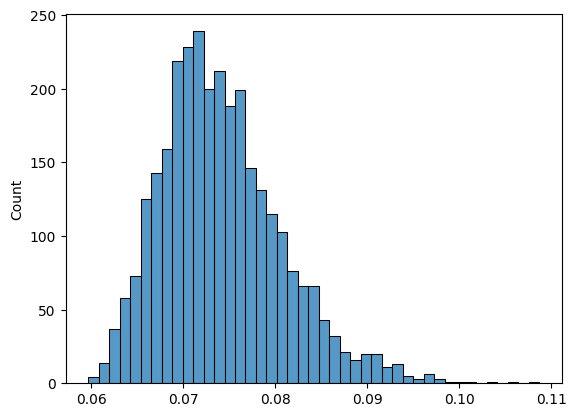

In [16]:
import seaborn as sns
sns.histplot([i['err'] for i in y])

In [17]:
X.shape

(3000, 32)

# Train the accuracy model

In [18]:
def aux_err(train_x, train_y):
    import numpy as np
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from catboost import CatBoostRegressor, Pool
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=args.seed)

    models, errs = [], []
    X, y = train_x, train_y
    for train_idx, test_idx in kfold.split(X, y):
        model = CatBoostRegressor(iterations=10000, learning_rate=0.1, depth=6, random_seed=args.seed,
                                loss_function='RMSE', verbose=True, early_stopping_rounds=1000)
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train, eval_set=Pool(X_test, y_test), use_best_model=True, verbose=500)
        
        y_pred = model.predict(X_test)
        models.append(model)
        
        err = mean_absolute_error(y_test, y_pred)
        errs.append(err)

    return models, errs

In [19]:
train_len = 2000
train_x, train_y = X[:train_len], y[:train_len]
test_x, test_y = X[train_len:], y[train_len:]
print('train data shape: ', train_x.shape, '\ntest data shape: ', test_x.shape)

trn_x = train_x
trn_y = np.array([i['err'] for i in train_y])
tst_x = test_x
tst_y = np.array([i['err'] for i in test_y])
err_models, mae_errs = aux_err(trn_x, trn_y)

train data shape:  (2000, 32) 
test data shape:  (1000, 32)
0:	learn: 0.0065941	test: 0.0062508	best: 0.0062508 (0)	total: 49.4ms	remaining: 8m 14s
500:	learn: 0.0004684	test: 0.0034192	best: 0.0034184 (494)	total: 509ms	remaining: 9.66s
1000:	learn: 0.0000771	test: 0.0033833	best: 0.0033833 (1000)	total: 963ms	remaining: 8.65s
1500:	learn: 0.0000149	test: 0.0033832	best: 0.0033830 (1435)	total: 1.41s	remaining: 8.01s
2000:	learn: 0.0000031	test: 0.0033831	best: 0.0033830 (1435)	total: 1.86s	remaining: 7.45s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.003383014562
bestIteration = 1435

Shrink model to first 1436 iterations.
0:	learn: 0.0065456	test: 0.0064719	best: 0.0064719 (0)	total: 2.31ms	remaining: 23.1s
500:	learn: 0.0004808	test: 0.0034766	best: 0.0034766 (500)	total: 460ms	remaining: 8.72s
1000:	learn: 0.0000800	test: 0.0034574	best: 0.0034572 (995)	total: 909ms	remaining: 8.17s
1500:	learn: 0.0000153	test: 0.0034548	best: 0.0034548 (1500)	total: 1.36s

In [21]:
mae_errs

[0.002642881368974786,
 0.002682193805440492,
 0.002689515823936638,
 0.0026670631837035653,
 0.0024396533740014335]

In [20]:
import pickle
d = './'
pickle.dump(err_models, open(d + 'err_models_2000.pkl', 'wb'))

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
pred_y_list = []
for model in err_models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y)
pred_y = np.array(pred_y_list).mean(axis=0)
mse_err = mean_squared_error(tst_y, pred_y)
mae_err = mean_absolute_error(tst_y, pred_y)
print('mse_err: ', mse_err, '\nmae_err: ', mae_err)

mse_err:  3.119176230980939e-08 
mae_err:  0.00013774183562903893


In [23]:
def get_pred_err(X):
    pred_y_list = []
    for model in err_models:
        pred_y = model.predict(X)
        pred_y_list.append(pred_y)
    return np.array(pred_y_list).mean(axis=0)

In [24]:
get_pred_err(test_x[:10])

array([0.07288487, 0.07184961, 0.0827488 , 0.07322738, 0.07975967,
       0.07355887, 0.07474605, 0.07247989, 0.08987908, 0.06951074])

# Get the params and flops

In fact, in neural architecture search problems, the number of parameters and flops is not an expensive task and can be obtained directly.

In [25]:
# ignore this cell
## Nevertheless, the model is better because the \
## number of model parameters is evenly distributed than the accuracy

# def aux_flops(train_x, train_y):
def aux_params(train_x, train_y):
    import numpy as np
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from catboost import CatBoostRegressor, Pool
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=args.seed)

    models, errs = [], []
    X, y = train_x, train_y
    for train_idx, test_idx in kfold.split(X, y):
        model = CatBoostRegressor(iterations=10000, learning_rate=0.1, depth=6, random_seed=args.seed,
                                loss_function='RMSE', verbose=True, early_stopping_rounds=1000)
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train, eval_set=Pool(X_test, y_test), use_best_model=True, verbose=500)
        
        y_pred = model.predict(X_test)
        models.append(model)
        
        err = mean_squared_error(y_test, y_pred)
        errs.append(err)

    return models, errs

In [26]:
def get_pred_params_direct(X):
    return benchmark.evaluate(X)[:, 1]

In [27]:
# def get_pred_flops_direct(X):
#     return benchmark.evaluate(X)[:, 2]

In [29]:
real_param = get_pred_params_direct(test_x[:10])
# real_flops = get_pred_flops_direct(test_x[:10])
real_param

array([1160170.,  828202.,  825386., 1069802.,  752170., 1049962.,
        999658.,  703914.,  807914.,  915818.])